In [1]:

import numpy as np
import scipy.stats as sps
import time
from statsmodels.stats.multitest import multipletests
import pickle
import multiprocessing as mp
from scipy import stats
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

In [1]:
d = pickle.load(open('/BS/mlcysec2/work/robust-segmentation/code/hrnet_seg/acdc_logs/agg_stats/agg_stats.pkl', 'rb'))
for k, v in d.items():
    for k_, v_ in v.items():
        print(k_, v_)

NameError: name 'pickle' is not defined

In [20]:
def mode(sample, num_classes):
    # for every sample in a pixel 
    c = stats.mode(sample)[0][0]
    cnt = np.sum(sample == c) 
    return c, cnt

def map_test(args):
    sample, n, num_classes, tau = args # arguments a tuple to be compatible with multiprocessing map
    c, cnt = mode(sample, num_classes) # mode class, frequency of mode
    return c, sps.binom_test(cnt, n, tau, alternative='greater'), cnt # perform a test s.t. probability of success is tau

def certify(num_classes, sample, n, sigma, tau, alpha, abstain=-1, parallel=False, correction='holm', kfwer_k=1):
    # sample (1024, 2048, n0+n)
    assert isinstance(sample, np.ndarray)
    shape = sample.shape # (1100, 2097152)
    assert len(shape) == 2
    t0 = time.time()
    n_samples = shape[0] # nr samples
    #assert(n_samples == n0 + n)
    K = shape[1] # nr points (number of pixels = 1024*2048)
    if parallel:
        with mp.Pool() as pool:
            c_ps = pool.map(map_test, [(sample[:, i],  n, num_classes, tau) for i in range(K) ]) # ((1100,), 100, 1000, 19, 0.75)
    else:
        c_ps = map(map_test, [(sample[:, i], n, num_classes, tau) for i in range(K) ])

    # len(c_ps)=2097152, made of 2-tuples (mode-class, binom_test result)
    classes, ps, cnt = zip(*c_ps)
    classes = np.array(list(classes))
    ps = np.array(list(ps))
    t1 = time.time()
    if correction == 'kfwer':
        sortind = np.argsort(ps)
        pvals = np.take(ps, sortind)
        ntests = len(pvals)
        alpha_ = kfwer_k * alpha / np.arange(ntests, 0, -1)
        alpha_[:kfwer_k] = kfwer_k * alpha / ntests
        notreject = pvals > alpha_
        nr_index = np.nonzero(notreject)[0]
        if nr_index.size == 0:
            # nonreject is empty, all rejected
            notrejectmin = len(pvals)
        else:
            notrejectmin = np.min(nr_index)
        notreject[notrejectmin:] = True
        reject_ = ~notreject
        reject = np.empty_like(reject_)
        reject[sortind] = reject_
    else:
        reject, _, _ , _= multipletests(ps, alpha=alpha, method=correction)
    I = np.logical_not(reject)
    classes[I] = abstain
    t2 = time.time()
        #time_total = t2 - t0
    time_pvals = t1 - t0
    time_correction = t2 - t1
    radius = sigma * sps.norm.ppf(tau)
    return classes, ps, radius, (time_pvals, time_correction), cnt

In [21]:
num_classes = 19 + 1
n = 100
sigma = 0.25
tau = 0.75
alpha = 0.001

In [22]:
out_pred = pickle.load(open('/BS/mlcysec/work/robust-segmentation/code/hrnet_seg/tblogs/GOPR0476_frame_000931_300_logits.pkl', 'rb'))[:n]
# baseline_pred = pickle.load(open('/BS/mlcysec/work/robust-segmentation/code/hrnet_seg/tblogs/GOPR0476_frame_000931_300_logits.pkl', 'rb'))

In [23]:
out_pred = F.softmax(torch.tensor(out_pred), dim=1).cpu().numpy()
s = out_pred.argmax(axis=1)
print("Sample", s.shape, " Posteriors", out_pred.shape)

Sample (100, 1024, 2048)  Posteriors (100, 19, 1024, 2048)


In [26]:
s = np.reshape(s, (n, 1024*2048))
classes_certify, pvals, radius, (t1, t2), cnt = certify(num_classes-1, s, n, sigma, tau, alpha, abstain=num_classes-1, parallel=True, correction='bonferroni') 

In [27]:
classes_certify = classes_certify.reshape(1024*2048)
top_count = np.array(cnt).reshape(1024*2048)
pvals = np.array(pvals).reshape(1024*2048)
abstain_idcs = classes_certify == (num_classes-1)
certify_idcs = classes_certify != (num_classes-1)

In [28]:
abstain_cnt = top_count[abstain_idcs]
certify_cnt = top_count[certify_idcs]
abstain_pvals = pvals[abstain_idcs]
certify_pvals = pvals[certify_idcs]

In [29]:
print("(Certified) Mean top-ratio:", np.mean(certify_cnt)/n)
print("(Certified) Min top-ratio:", np.min(certify_cnt)/(n))
print("(Certified) Max top-ratio:", np.max(certify_cnt)/(n))

(Certified) Mean top-ratio: 1.0
(Certified) Min top-ratio: 1.0
(Certified) Max top-ratio: 1.0


In [30]:
print("(Abstain) Mean top-ratio:", np.mean(abstain_cnt)/n)
print("(Abstain) Min top-ratio:", np.min(abstain_cnt)/(n))
print("(Abstain) Max top-ratio", np.max(abstain_cnt)/(n), "| Max count:", np.sum(abstain_cnt == np.max(abstain_cnt)))

(Abstain) Mean top-ratio: 0.7845640168469398
(Abstain) Min top-ratio: 0.16
(Abstain) Max top-ratio 0.96 | Max count: 122517


# Visualization of the posteriors distribution for a certified vs. an abstain pixel with different top-class ratios

(0.0, 1.0)

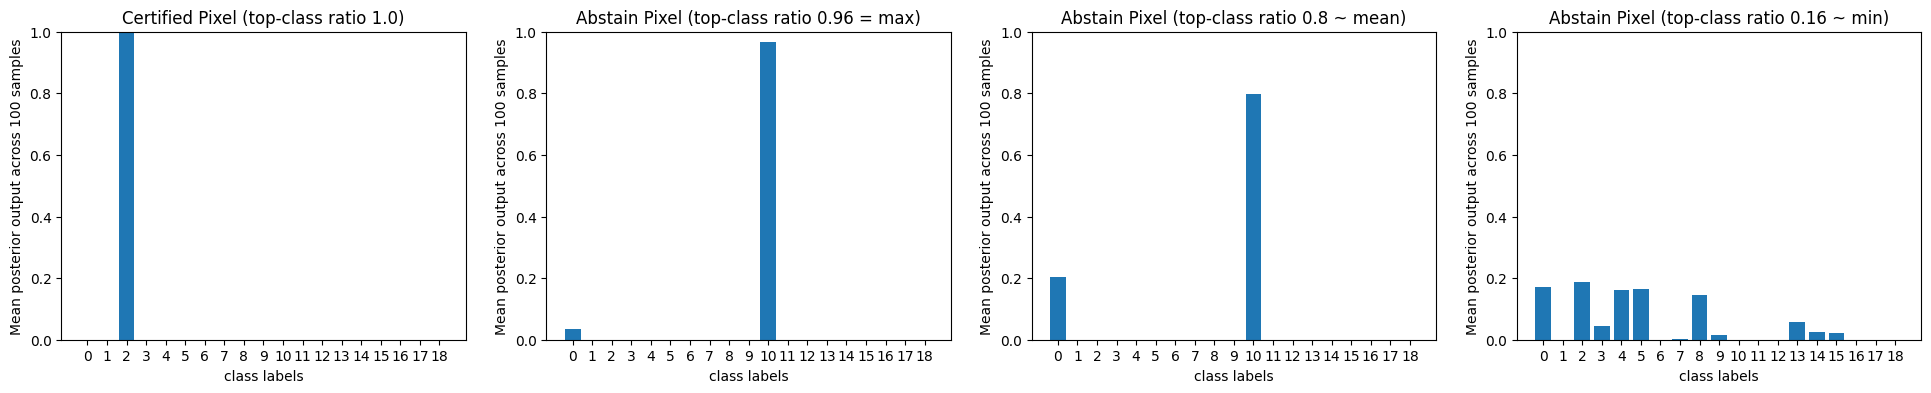

In [40]:
mean_posteriors = out_pred.mean(axis=0).reshape(19, 1024*2048)
certified_posteriors = mean_posteriors[:, certify_idcs]
abstain_porteriors = mean_posteriors[:, abstain_idcs]

fix, ax = plt.subplots(1, 4, figsize=(24, 4))
ax[0].bar(range(0, 19, 1), certified_posteriors[:, 10])
ax[0].set_xticks(range(0, 19, 1))
ax[0].set_ylim(0, 1.0)
top_class_ratio = (certify_cnt[0]/n).round(2)
ax[0].set(xlabel='class labels', ylabel='Mean posterior output across 100 samples')
ax[0].set_title(f"Certified Pixel (top-class ratio {top_class_ratio})")

ax[1].bar(range(0, 19, 1), abstain_porteriors[:, abstain_cnt == np.max(abstain_cnt)][:, 20])
ax[1].set_xticks(range(0, 19, 1))
ax[1].set(xlabel='class labels', ylabel='Mean posterior output across 100 samples')
top_class_ratio = (np.max(abstain_cnt)/n).round(2)
ax[1].set_title(f"Abstain Pixel (top-class ratio {top_class_ratio} = max)")
ax[1].set_ylim(0, 1.0)

ax[2].bar(range(0, 19, 1), abstain_porteriors[:, np.isclose(abstain_cnt, [np.mean(abstain_cnt)], atol=2)][:, 0])
ax[2].set_xticks(range(0, 19, 1))
ax[2].set(xlabel='class labels', ylabel='Mean posterior output across 100 samples')
top_class_ratio = (abstain_cnt[np.isclose(abstain_cnt, [np.mean(abstain_cnt)], atol=2)][0]/n).round(2)
ax[2].set_title(f"Abstain Pixel (top-class ratio {top_class_ratio} ~ mean)")
ax[2].set_ylim(0, 1.0)

ax[3].bar(range(0, 19, 1), abstain_porteriors[:, abstain_cnt == np.min(abstain_cnt)][:, 0])
ax[3].set_xticks(range(0, 19, 1))
ax[3].set(xlabel='class labels', ylabel='Mean posterior output across 100 samples')
top_class_ratio = (np.min(abstain_cnt)/n).round(2)
ax[3].set_title(f"Abstain Pixel (top-class ratio {top_class_ratio} ~ min)")
ax[3].set_ylim(0, 1.0)



# Distribution of top-class ratio in certified pixels

Text(0, 0.5, 'Count')

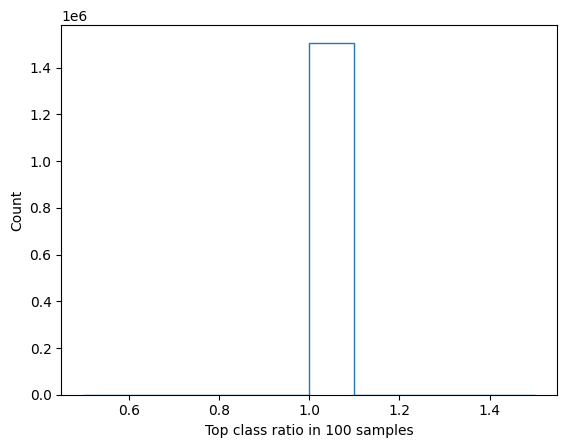

In [41]:
counts, bins = np.histogram(certify_cnt/n)
plt.stairs(counts, bins)
plt.xlabel('Top class ratio in 100 samples')
plt.ylabel('Count')

# Distribution of top-class ratio in abstain pixels

Text(0, 0.5, 'Count')

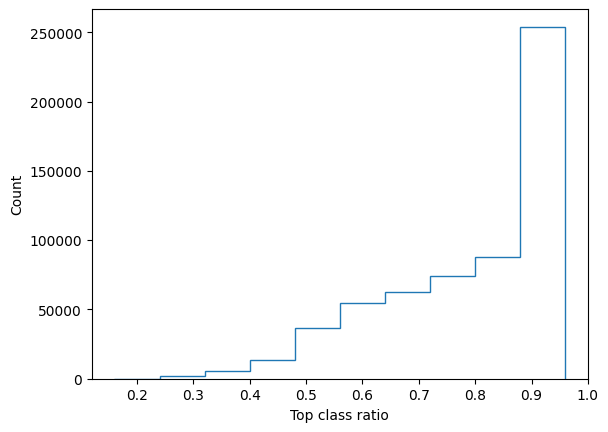

In [42]:
counts, bins = np.histogram(abstain_cnt/n)
plt.stairs(counts, bins)
plt.xlabel('Top class ratio')
plt.ylabel('Count')

In [ ]:
# Distribution of pvals

[Text(0.5, 0, 'abstain pvals'), Text(0, 0.5, 'count')]

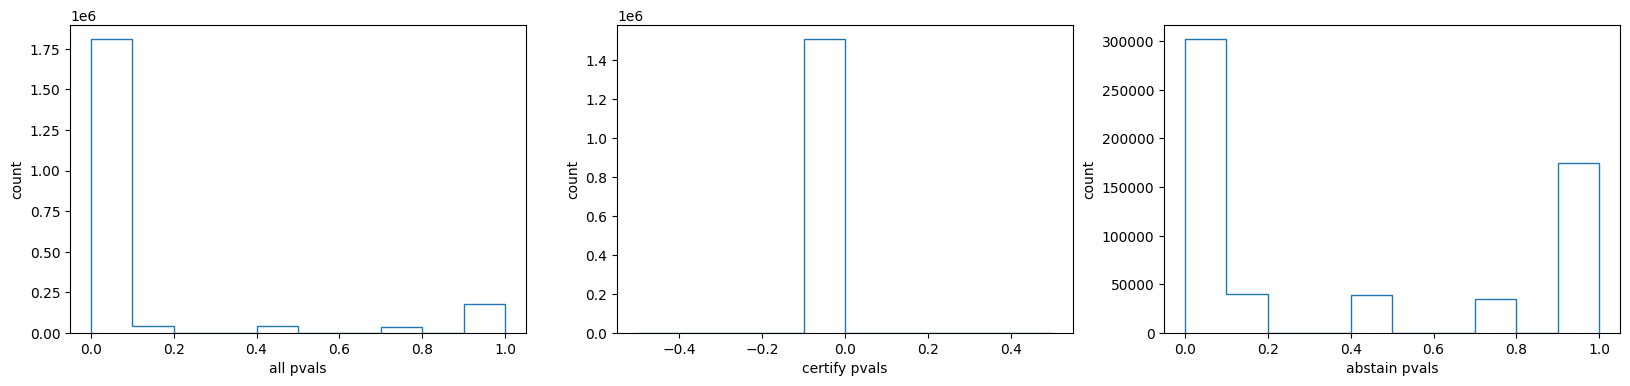

In [44]:
counts, bins = np.histogram(pvals)
fix, ax = plt.subplots(1, 3, figsize=(20, 4))
ax[0].stairs(counts, bins)
ax[0].set(xlabel='all pvals', ylabel='count')

counts, bins = np.histogram(certify_pvals)
ax[1].stairs(counts, bins)
ax[1].set(xlabel='certify pvals', ylabel='count')

counts, bins = np.histogram(abstain_pvals)
ax[2].stairs(counts, bins)
ax[2].set(xlabel='abstain pvals', ylabel='count')